In [1]:
# 🧠 U-NET FOR IMAGE DENOISING (MNIST)
# =====================================
# Task: Remove synthetic noise from MNIST digits using a simple U-Net.
# =====================================

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set reproducibility
torch.manual_seed(42)

# Prepare noisy MNIST dataset
class NoisyMNIST(torch.utils.data.Dataset):
    def __init__(self, train=True):
        self.data = datasets.MNIST("data", train=train, download=True, transform=transforms.ToTensor())

    def __getitem__(self, idx):
        clean_img, _ = self.data[idx]
        noise = torch.randn_like(clean_img) * 0.5
        noisy_img = torch.clamp(clean_img + noise, 0., 1.)
        return noisy_img, clean_img

    def __len__(self):
        return len(self.data)

train_loader = DataLoader(NoisyMNIST(train=True), batch_size=64, shuffle=True)
test_loader = DataLoader(NoisyMNIST(train=False), batch_size=64)

In [2]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        def CBR(in_ch, out_ch):  # Conv → BatchNorm → ReLU
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )

        # Encoder
        self.enc1 = nn.Sequential(CBR(1, 32), CBR(32, 32))
        self.enc2 = nn.Sequential(CBR(32, 64), CBR(64, 64))
        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(CBR(64, 128), CBR(128, 128))

        # Decoder
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(CBR(128, 64), CBR(64, 64))

        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(CBR(64, 32), CBR(32, 32))

        self.final = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)  # [B, 32, 28, 28]
        e2 = self.enc2(self.pool(e1))  # [B, 64, 14, 14]

        b = self.bottleneck(self.pool(e2))  # [B, 128, 7, 7]

        d1 = self.up1(b)  # [B, 64, 14, 14]
        d1 = self.dec1(torch.cat([d1, e2], dim=1))  # skip connection

        d2 = self.up2(d1)  # [B, 32, 28, 28]
        d2 = self.dec2(torch.cat([d2, e1], dim=1))

        return torch.sigmoid(self.final(d2))  # Keep in [0, 1]

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(5):
    model.train()
    total_loss = 0
    for noisy, clean in tqdm(train_loader):
        noisy, clean = noisy.to(device), clean.to(device)
        pred = model(noisy)
        loss = loss_fn(pred, clean)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

100%|██████████| 938/938 [05:09<00:00,  3.03it/s]


Epoch 1, Loss: 0.0263


100%|██████████| 938/938 [05:06<00:00,  3.06it/s]


Epoch 2, Loss: 0.0090


100%|██████████| 938/938 [05:19<00:00,  2.94it/s]


Epoch 3, Loss: 0.0085


100%|██████████| 938/938 [05:03<00:00,  3.09it/s]


Epoch 4, Loss: 0.0083


100%|██████████| 938/938 [05:04<00:00,  3.08it/s]

Epoch 5, Loss: 0.0081


In [22]:
# Save entire model + optimizer state (for resuming training or inference)
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}
import os
if not os.path.exists("unet_checkpoints"):
    os.makedirs("unet_checkpoints")
path = "unet_checkpoints/unet_mnist.pth"
torch.save(checkpoint, path)
print("Model saved to ", path)

Model saved to  unet_checkpoints/unet_mnist.pth


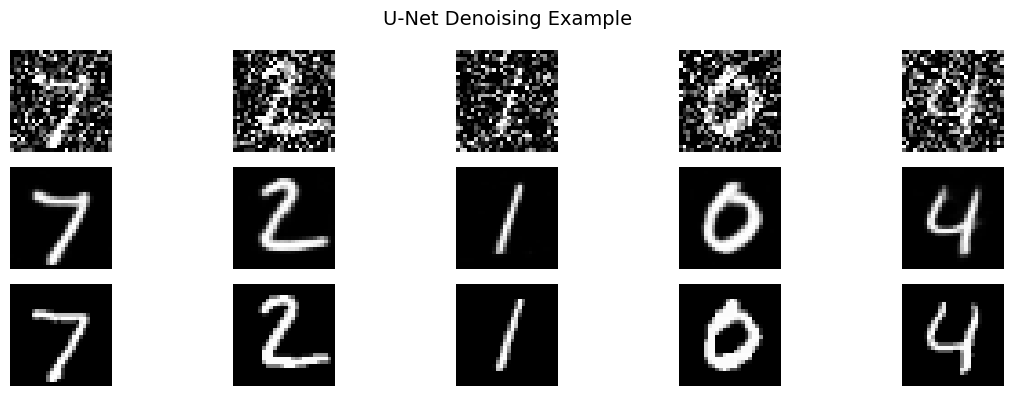

In [19]:
model.eval()
noisy_batch, clean_batch = next(iter(test_loader))
noisy_batch = noisy_batch.to(device)
with torch.no_grad():
    denoised = model(noisy_batch).cpu()

plt.figure(figsize=(12, 4))
for i in range(5):
    for j, img in enumerate([noisy_batch.cpu(), denoised, clean_batch]):
        plt.subplot(3, 5, i + 1 + j * 5)
        plt.imshow(img[i][0], cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.ylabel(["Noisy", "Denoised", "Clean"][j])
plt.suptitle("U-Net Denoising Example", fontsize=14)
plt.tight_layout()
plt.show()